## Model Metrics Analysis for LLaMa-2 benchmarking

In [110]:
import glob
import time
import json
import copy
import asyncio
import logging
import itertools
import sagemaker
import pandas as pd
from globals import *
from typing import Dict, List
from transformers import AutoTokenizer
from sagemaker.predictor import Predictor
from utils import load_config, count_tokens
from sagemaker.serializers import JSONSerializer

In [111]:
# global constants
!pygmentize globals.py

import os
from enum import Enum
from pathlib import Path

CONFIG_FILE: str = "config.yml"
DATA_DIR: str = "data"
PROMPTS_DIR = os.path.join(DATA_DIR, "prompts")
METRICS_DIR = os.path.join(DATA_DIR, "metrics")
MODELS_DIR = os.path.join(DATA_DIR, "models")
DATASET_DIR = os.path.join(DATA_DIR, "dataset")
DIR_LIST = [DATA_DIR, PROMPTS_DIR, METRICS_DIR, MODELS_DIR, DATASET_DIR]
TOKENIZER_DIR = 'llama2_tokenizer'

_ = list(map(lambda x: os.makedirs(x, exist_ok=True), DIR_LIST))

ENDPOINT_LIST_FPATH:str = os.path.join(MODELS_DIR, "endpoints.json")
REQUEST_PAYLOAD_FPATH:str = os.path.join(PROMPTS_DIR, "payload.jsonl")
RESULTS_FPATH:str = os.path.join(METRICS_DIR, "results.csv")
class TRUNCATE_POLICY(str, Enum):
    AT_PROMPT_TOKEN_LENGTH = 'at-prompt-token-length'    


In [112]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [113]:
config = load_config(CONFIG_FILE)
logger.info(json.dumps(config, indent=2))

[2024-01-04 08:26:27,177] p25292 {635462509.py:2} INFO - {
  "aws": {
    "region": "us-east-1",
    "sagemaker_execution_role": "arn:aws:iam::015469603702:role/SageMakerRepoRole"
  },
  "dir": {
    "models": "anycompanyfile2039/models",
    "prompts": "data/prompts"
  },
  "dataset": {
    "file": "wikimqa_e.jsonl"
  },
  "prompt": {
    "language": "en",
    "template_file": "prompt_template.txt",
    "min_length_in_tokens": 305,
    "max_length_in_tokens": 3997
  },
  "inference_parameters": {
    "do_sample": true,
    "temperature": 0.7,
    "top_p": 0.92,
    "top_k": 120,
    "max_new_tokens": 100,
    "truncate": "at-prompt-token-length"
  },
  "models": [
    {
      "model_id": "meta-textgenerationneuron-llama-2-13b-f",
      "model_version": "1.0.0",
      "ep_name": "llama-2-13b-inf2-24xlarge",
      "instance_type": "ml.inf2.24xlarge",
      "image_uri": "763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.24.0-neuronx-sdk2.14.1",
      "deploy": true,
      "ins

In [1]:
df = pd.read_csv(RESULTS_FPATH)
df['instance_type'] = 'ml.inf2.48xlarge'
# df['concurrency'] = 2
logger.info(f"{RESULTS_FPATH} contains {df.shape[0]} results")

In [2]:
df.head()

In [3]:
df_failed = df[df.completion_tokens.isna()]
logger.info(f"{len(df_failed)} requests failed out of {len(df)}")

In [ ]:
df_failed

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8,6

<Axes: title={'center': 'Prompt length distribution'}, xlabel='Prompt length (tokens)', ylabel='Count'>

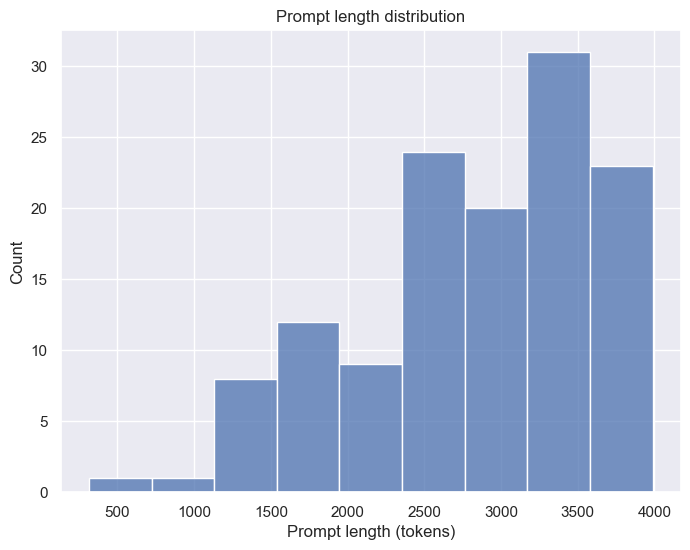

In [149]:

plt.xlabel("Prompt length (tokens)")
plt.title(f"Prompt length distribution")
sns.histplot(data=df, x="prompt_tokens")



<Axes: xlabel='latency', ylabel='Proportion'>

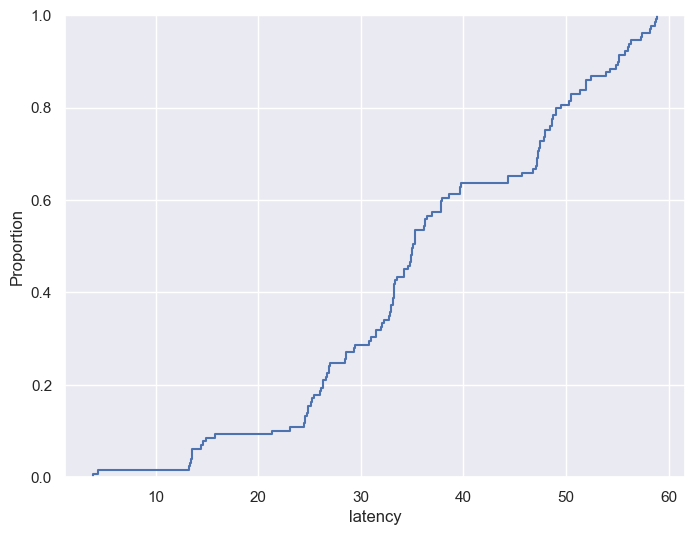

In [119]:
sns.ecdfplot(data=df, x="latency")

<Axes: xlabel='prompt_tokens', ylabel='latency'>

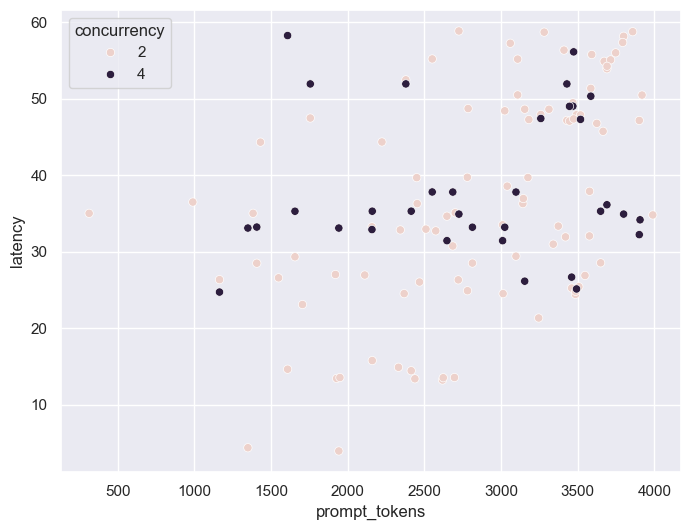

In [120]:
sns.scatterplot(data=df, x="prompt_tokens", y="latency", hue="concurrency")

In [4]:
df_prompt_len_and_latency = df[['prompt_tokens', 'latency', 'concurrency', 'ModelName', 'instance_type']]
bins = list(range(0, 5000, 500))
labels = []
for i, b in enumerate(bins):
    if i == 0:
        continue
    elif i == 1:
        labels.append(f"<{b}")
    else:
        labels.append(f'{bins[i-1]}-{b}')

df_prompt_len_and_latency['label'] = pd.cut(df_prompt_len_and_latency['prompt_tokens'],
                                             bins=bins,
                                             labels=labels)
    
labels = labels[:-1]
df_prompt_len_and_latency

In [122]:
df_prompt_len_and_latency.label.value_counts()

label
3000-3500    40
3500-4000    29
2500-3000    20
2000-2500    17
1500-2000    13
1000-1500     8
<500          1
500-1000      1
4000-4500     0
Name: count, dtype: int64

In [5]:
df_prompt_len_and_latency[df_prompt_len_and_latency.label == "4000-4500"]

<Axes: title={'center': 'Effect of token length on inference latency'}, xlabel='Prompt length (tokens)', ylabel='Latency (seconds)'>

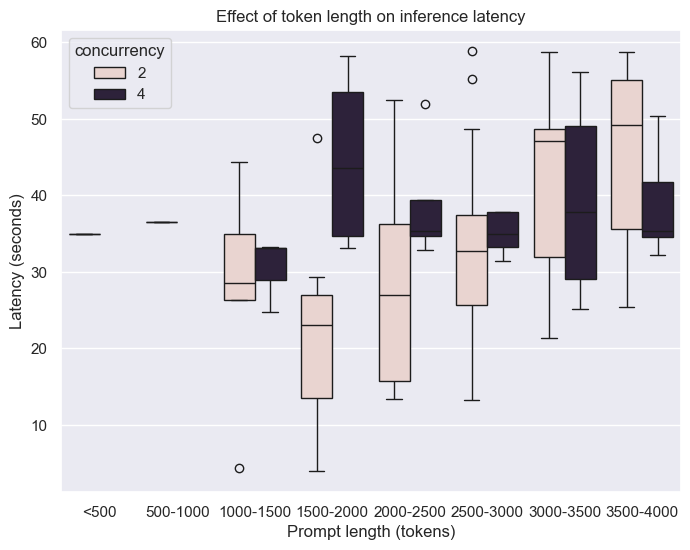

In [130]:
plt.xlabel("Prompt length (tokens)")
plt.ylabel("Latency (seconds)")
plt.title(f"Effect of token length on inference latency")
sns.boxplot(data=df_prompt_len_and_latency, x="label", y="latency", hue="concurrency", order=labels)